#  Importing needed libraries

In [1]:
import numpy as np 
import pandas as pd 
import cv2
import time
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
import os

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#  Loading *labels*

In [3]:
labels = pd.read_csv(r'D:\Study_3\GTSRB_new\signnames.csv')

# Check point
print(labels.head())
print()

print(labels.iloc[0][1])  # Speed limit (20km/h)
print(labels['SignName'][1]) # Speed limit (30km/h)


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)

Speed limit (20km/h)
Speed limit (30km/h)


#  Loading trained Keras CNN model for Classification

(1, 32, 32)


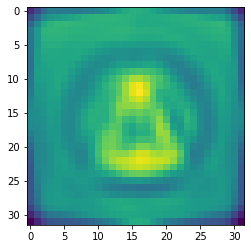

In [4]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
model = load_model(r'D:\Study_3\GTSRB_new\training\new_model.h5')

# Loading mean image to use for preprocessing further (mean image substraction)
with open(r'D:\Study_3\mean_image_gray.pickle', 'rb') as f:
    mean = pickle.load(f) 
    
print(mean['mean_image_gray'].shape) 
plt.imshow(mean['mean_image_gray'].reshape(32, 32, 1))

# Loading YOLO v3 network by OpenCV dnn library

## Loading *trained weights* and *cfg file* into the Network

In [5]:
path_to_weights = r'D:\Study_3\weights\yolov3_ts_train_last.weights'
path_to_cfg = r'D:\Study_3\yolov3_ts_test.cfg'

# Loading trained YOLO v3 weights and cfg configuration file by 'dnn' library from OpenCV
network = cv2.dnn.readNetFromDarknet(path_to_cfg, path_to_weights)

# To use with GPU
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
network.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

## Getting output layers where detections are made 

In [6]:
# Getting names of all YOLO v3 layers
layers_all = network.getLayerNames()

# Check point
# print(layers_all)

# Getting only detection YOLO v3 layers that are 82, 94 and 106
layers_names_output = [layers_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

# Check point
print()
print(layers_names_output)  



['yolo_82', 'yolo_94', 'yolo_106']


## Setting probability, threshold and colour for bounding boxes

In [7]:
# Minimum probability to eliminate weak detections
probability_minimum = 0.2

# Setting threshold to filtering weak bounding boxes by non-maximum suppression
threshold = 0.2

# Generating colours for bounding boxes
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(type(colours))  
print(colours.shape)
print(colours[0])  


<class 'numpy.ndarray'>
(43, 3)
[ 78 212  19]


# Reading input video

In [12]:
# Reading video from a file by VideoCapture object of cv2 class
video = cv2.VideoCapture(r'C:\Users\ronak\Desktop\video_for_test\input_fr.mp4')

# Writer that will be used to write processed frames
writer = None

# Variables for spatial dimensions of the frames
h, w = None, None

In [13]:
# cut frame preprocessing...
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    # img = img/255
    return img

# Processing frames in the loop

In [14]:
%matplotlib inline

# Setting default size of plots
plt.rcParams['figure.figsize'] = (3, 3)

# Variable for counting total amount of frames
f = 0

# Variable for counting total processing time
t = 0

# Catching frames in the loop
while True:
    # Capturing frames one-by-one
    ret, frame = video.read()

    # If the frame was not retrieved
    if not ret:
        break
       
    # Getting spatial dimensions of the frame for the first time
    if w is None or h is None:
        # Slicing two elements from tuple
        h, w = frame.shape[:2]

    # Blob from current frame
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)

    # Forward pass with blob through output layers
    network.setInput(blob)
    start = time.time()
    output_from_network = network.forward(layers_names_output)
    end = time.time()

    # Increasing counters
    f += 1
    t += end - start

    # Spent time for current frame
    print('Frame number {0} took {1:.5f} seconds'.format(f, end - start))

    # Lists for detected bounding boxes, confidences and class's number
    bounding_boxes = []
    confidences = []
    class_numbers = []

    # Going through all output layers after feed forward pass
    for result in output_from_network:
        # Going through all detections from current output layer
        for detected_objects in result:
            # Getting 80 classes' probabilities for current detected object
            scores = detected_objects[5:]
            # Getting index of the class with the maximum value of probability
            class_current = np.argmax(scores)
            # Getting value of probability for defined class
            confidence_current = scores[class_current]

            # Eliminating weak predictions by minimum probability
            if confidence_current > probability_minimum:
                # Scaling bounding box coordinates to the initial frame size
                box_current = detected_objects[0:4] * np.array([w, h, w, h])

                # Getting top left corner coordinates
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                # Adding results into prepared lists
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
                

    # Implementing non-maximum suppression of given bounding boxes
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    # Checking if there is any detected object been left
    if len(results) > 0:
        # Going through indexes of results
        for i in results.flatten():
            # Bounding box coordinates, its width and height
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            
            
            # Cut fragment with Traffic Sign
            c_ts = frame[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]

            
            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                c_ts = preprocessing(c_ts)
                # Getting preprocessed blob with Traffic Sign of needed shape
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
                blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_gray']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)

                # Feeding to the Keras CNN model to get predicted label among 43 classes
                scores = model.predict(blob_ts)

                # Scores is given for image with 43 numbers of predictions for each class
                # Getting only one class with maximum value
                prediction = np.argmax(scores)
                # print(labels['SignName'][prediction])


                # Colour for current bounding box
                colour_box_current = colours[class_numbers[i]].tolist()

                # Drawing bounding box on the original current frame
                cv2.rectangle(frame, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                       confidences[i])

                # Putting text with label and confidence on the original image
                cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)


    # Initializing writer only once
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter(r'C:\Users\ronak\Desktop\video_for_test\fr_result.mp4', fourcc, 25,
                                 (frame.shape[1], frame.shape[0]), True)

    # Write processed current frame to the file
    writer.write(frame)


# Releasing video reader and writer
video.release()
writer.release()

Frame number 1 took 0.59359 seconds
Frame number 2 took 0.58769 seconds
Frame number 3 took 0.58954 seconds
Frame number 4 took 0.61808 seconds
Frame number 5 took 0.58429 seconds
Frame number 6 took 0.58412 seconds
Frame number 7 took 0.58314 seconds
Frame number 8 took 0.58485 seconds
Frame number 9 took 0.58183 seconds
Frame number 10 took 0.57891 seconds
Frame number 11 took 0.59234 seconds
Frame number 12 took 0.58388 seconds
Frame number 13 took 0.58161 seconds
Frame number 14 took 0.62239 seconds
Frame number 15 took 0.58463 seconds
Frame number 16 took 0.61265 seconds
Frame number 17 took 0.59823 seconds
Frame number 18 took 0.62056 seconds
Frame number 19 took 0.59286 seconds
Frame number 20 took 0.59539 seconds
Frame number 21 took 0.57731 seconds
Frame number 22 took 0.56943 seconds
Frame number 23 took 0.57469 seconds
Frame number 24 took 0.58799 seconds
Frame number 25 took 0.51744 seconds
Frame number 26 took 0.40042 seconds
Frame number 27 took 0.40791 seconds
Frame numb

# FPS results

In [15]:
print('Total number of frames', f)
print('Total amount of time {:.5f} seconds'.format(t))
print('FPS:', round((f / t), 1))

Total number of frames 101
Total amount of time 67.97068 seconds
FPS: 1.5


In [16]:
# Saving locally without committing
from IPython.display import FileLink

FileLink(r'C:\Users\ronak\Desktop\video_for_test\fr_result.mp4')

C:\Users\ronak\Desktop\video_for_test\fr_result.mp4

# Result Video 

In [33]:
from IPython.display import Video

Video(r"C:\Users\ronak\Desktop\video_for_test\fr_result.mp4", width=1000, height=576, embed=True)
